In [1]:
from time import time

start = time()

## Regex classifier

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import re


#idea credit https://www.linkedin.com/pulse/regex-one-pattern-rule-them-all-find-bring-darkness-bind-carranza/
class RegexClassifier(BaseEstimator, RegressorMixin):
    """
    Language Classifier using Regular Expressions
    """

    language_regex_dict = {
        'el': r'([\u0370-\u03FF]+)\s?',  # Greek
        'en': r'([a-zA-Z]+)\s?',  # English
    }

    # STATIC INITALIZATION BLOCK
    # pre-compie all expressions to save execution time
    for lang in language_regex_dict.keys():
        language_regex_dict[lang] = re.compile(language_regex_dict[lang])


    def __init__(self, include_greeklish=True):
        """
        Initialize a new :class:`RegexClassifier` instance.

        :param include_greeklish: Optional. If True, include Greeklish in the language identification process.
        """
        self.include_greeklish = include_greeklish

    def predict(self, x):
        preds = []

        for text in x:
            pred = None

            if self.include_greeklish and \
                re.search(RegexClassifier.language_regex_dict["el"], text) and \
                re.search(RegexClassifier.language_regex_dict["en"], text):
                    pred = "greeklish"

            for lang_code, regex_pattern in RegexClassifier.language_regex_dict.items():
                match = re.search(regex_pattern, text)
                if match:
                    pred = lang_code
                    break
            preds.append(pred)
        return np.array(preds)
    
    def fit(self, x, y):
        return self

In [3]:
# Example usage
user_input_text = ["你好，これはサンプルです。안녕하세요", "this is an english sentence", "δεν αντεχω αλλο"]
detected_language = RegexClassifier().predict(user_input_text)
print(f"Detected Language Code: {detected_language}")

Detected Language Code: [None 'en' 'el']


## Defining the Gold Standard


https://aclanthology.org/L06-1229/
https://aclanthology.org/L04-1369/
https://huggingface.co/datasets/papluca/language-identification

In [4]:
import pandas as pd


def dataset_to_pd(dataset_dict: dict) -> pd.DataFrame:
    df_ls = []
    label_array = np.empty(shape=(sum([len(dataset) for dataset in dataset_dict.values()])), dtype=object)
    last_idx = -1

    for label, dataset in dataset_dict.items():
        new_last_idx = len(dataset) + last_idx
        label_array.put(np.arange(last_idx+1, new_last_idx+1, 1), label)
        last_idx = new_last_idx

        df_ls.append(pd.DataFrame(dataset))

    full_df = pd.concat(df_ls, ignore_index=True)
    full_df["set"] = label_array
    full_df.insert(0, "set", full_df.pop("set"))

    return full_df

In [5]:
from datasets import load_dataset


dataset_dict = load_dataset("papluca/language-identification")
dataset_dict

C:\Users\user\anaconda3\envs\manis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [6]:
gold1_df = dataset_to_pd(dataset_dict)
gold1_df

,set,labels,text
0,train,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,train,bg,размерът на хоризонталната мрежа може да бъде ...
2,train,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,train,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,train,ru,Он увеличил давление .
...,...,...,...
89995,test,zh,史料很充分，对岸的很多观点与大陆迥异啊。
89996,test,tr,"Örneğin, teşhis Yunanca bir kelimeden alındı (..."
89997,test,vi,Nếu lite/light chỉ đơn giản là mô tả một đặc t...
89998,test,bg,"Например, една щатска столица, която посетихме..."


In [7]:
gold1_df = gold1_df.loc[gold1_df.labels.eq("el") | gold1_df.labels.eq("en"), ["labels", "text"]]
gold1_df

,labels,text
18,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
39,en,Didnt really seem to work much.
40,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
49,en,Highly recommend for those who don't like bein...
75,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
89961,en,"It's super cute, really soft. Print is fine bu..."
89965,en,"One of them worked, the other one didn't. Ther..."
89978,en,I only received one out of the three strikers :(
89982,el,Οι οργανισμοί πρέπει να είναι σε θέση να μετρή...


In [8]:
head_url = "https://forum.warmane.com"
warmane_url = "https://forum.warmane.com/forumdisplay.php?f=20"

In [9]:
from src.util import fetch_soup
from tasks.warmane import parse_warmane_thread
from tqdm import tqdm


threads = []

for page in range(1, 9):
    url = warmane_url + f"&page={page}"
    soup = fetch_soup(url)

    print(f"Processing page {page} of 8...")
    thread_tags = soup.find_all("li", {"class": "threadbit"})
    for thread_tag in tqdm(thread_tags):
        thread = parse_warmane_thread(head_url, thread_tag)
        threads.append(thread)

Processing page 1 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.46it/s]


Processing page 2 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.47it/s]


Processing page 3 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.15it/s]


Processing page 4 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.57it/s]


Processing page 5 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.14it/s]


Processing page 6 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.55it/s]


Processing page 7 of 8...


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  4.67it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=272585


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.13it/s]


Processing page 8 of 8...


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:01<00:00,  4.24it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=278731


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.12it/s]


In [10]:
import itertools

# flatten nested lists 
posts = set(itertools.chain.from_iterable([thread.posts for thread in threads]))
len(posts)

414

In [11]:
import pandas as pd

warmane_df = pd.DataFrame.from_records([post.__dict__ for post in posts], index="id")
warmane_df.reply_to = warmane_df.reply_to.fillna(-1).astype(int)
warmane_df

,thread_id,author,contents,date,reply_to
id,,,,,
2926596,384475,Ripsin,"Kalhspera paides,\n\r\nEimai arketo kairo ston...",2018-05-22,-1
2473988,300013,v4gflo,geia sas.psaxnw ellhniko guild ston Deathwing ...,2015-06-17,-1
2420747,290921,AlexPan,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...",2015-03-24,-1
2981903,399822,xAchillesGate4x,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...,2019-03-03,-1
2879517,371804,Csdas,Opoios gnwrizei kati as mou kanei /w Dremoria ...,2017-11-29,-1
...,...,...,...,...,...
2877428,353812,Shiverbro,kalos private aksizei na ksekiniseis paidia?,2017-11-21,2875915
3069941,423611,crystallenia898,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...,2020-07-26,3068345
2801654,350071,Draculation,Bump! ICC25 6/12,2017-05-07,2795443


In [12]:
empty_contents = warmane_df.contents.apply(lambda x: x.isspace() | len(x)==0)
warmane_df[empty_contents]

,thread_id,author,contents,date,reply_to
id,,,,,
3082464,427259,malakas17,,2020-10-20,3081822
3113236,427259,malakas17,,2021-05-12,3113009
3099161,431660,malakas17,,2021-02-10,3096432
3113819,427259,malakas17,,2021-05-16,3113236
3099593,427259,boonick,,2021-02-14,3093400
3081820,427259,malakas17,,2020-10-16,3080427
3081822,427259,malakas17,,2020-10-16,3081820


In [13]:
warmane_df = warmane_df[~empty_contents]

In [14]:
regex_model = RegexClassifier(include_greeklish=False)
preds = regex_model.predict(warmane_df.contents)

In [15]:
warmane_df[preds=="en"].contents

id
2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
2959390               Bubblethesap Icecrown wotlk horde belf
2947119    den se vrisko kane add evvi  .\nmou leei den u...
                                 ...                        
2557881                          Paokara einai padou file :P
2602989    Me to plevro ton Allience ayti ti fora Oi <<An...
2877428         kalos private aksizei na ksekiniseis paidia?
2801654                                     Bump! ICC25 6/12
2873339    Kalhspera tha ithela na rwthsw an kapoios gnwr...
Name: contents, Length: 227, dtype: object

In [16]:
warmane_df[preds=="greeklish"].contents

Series([], Name: contents, dtype: object)

In [17]:
warmane_df[preds=="el"].contents

id
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2959391    Καλησπερα θα πας στις ιδιότητες (properties) σ...
2719776    Originally Posted by celphecil\n\nΚαλησπέρα Σω...
2971700    Ελληνικο guild , ψαχνουμε ατομα για runs ICC10...
                                 ...                        
2609122    πώρωση με τα μισά Dung, Quests και Raids bugge...
2707437    Λοιπόν μαγες,ξέρει κάποιος γιατί δεν γίνεται ν...
2777071    INACTIVE\n\n\n <Northern Defiance>  Καινούργια...
3069941    Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2410495    Εμπειρια εχω, αλλα δεν εχω χρονο...αυτο ειναι ...
Name: contents, Length: 180, dtype: object

In [18]:
labels = np.where(preds=="en", "greeklish", "el")
gold2_df = pd.DataFrame({"labels": labels, "text": warmane_df.contents})
gold2_df

,labels,text
id,,
2926596,greeklish,"Kalhspera paides,\n\r\nEimai arketo kairo ston..."
2473988,greeklish,geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747,el,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \..."
2981903,el,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517,greeklish,Opoios gnwrizei kati as mou kanei /w Dremoria ...
...,...,...
2877428,greeklish,kalos private aksizei na ksekiniseis paidia?
3069941,el,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2801654,greeklish,Bump! ICC25 6/12


In [19]:
gold_df = pd.concat([gold1_df, gold2_df])
gold_df

,labels,text
18,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
39,en,Didnt really seem to work much.
40,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
49,en,Highly recommend for those who don't like bein...
75,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
2877428,greeklish,kalos private aksizei na ksekiniseis paidia?
3069941,el,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2801654,greeklish,Bump! ICC25 6/12
2873339,greeklish,Kalhspera tha ithela na rwthsw an kapoios gnwr...


In [20]:
import os


gold_file = os.path.join("data", "gold.csv")
with open(gold_file, "w") as f:
    gold_df.to_csv(gold_file)
    print(f"Gold saved successfully as {gold_file}")

Gold saved successfully as data\gold.csv


## Youtube Crawling

In [21]:
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver


try:
    service = Service()
except Exception:
    service = Service(ChromeDriverManager().install())

options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument('--lang=en')
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36")

driver = webdriver.Chrome(service=service, options=options)

In [22]:
from tasks.youtube import scrape_youtube, extract_search_results, extract_comments


# "greek songs" search in Greek
search_url = "https://www.youtube.com/results?search_query=%CE%B5%CE%BB%CE%BB%CE%B7%CE%BD%CE%B9%CE%BA%CE%B1+%CF%84%CF%81%CE%B1%CE%B3%CE%BF%CF%85%CE%B4%CE%B9%CE%B1"
search_soup = scrape_youtube(driver, search_url, max_scrolls=15, verbose=True)

Scrolling (0 out of max 15)...
Scrolling (1 out of max 15)...
Scrolling (2 out of max 15)...
Scrolling (3 out of max 15)...
Scrolling (4 out of max 15)...
Scrolling (5 out of max 15)...
Scrolling (6 out of max 15)...
Scrolling (7 out of max 15)...
Scrolling (8 out of max 15)...
Scrolling (9 out of max 15)...
Scrolling (10 out of max 15)...
Scrolling (11 out of max 15)...
Scrolling (12 out of max 15)...
Scrolling (13 out of max 15)...
Scrolling (14 out of max 15)...
Scrolling (15 out of max 15)...


In [23]:
results = extract_search_results(search_soup)
results_df = pd.DataFrame({"title": results[0], "link": results[1]})
results_df

,title,link
0,"\n\nΠου 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημέ...",/watch?v=OdX0y96UPEA&pp=ygUjzrXOu867zrfOvc65zr...
1,\n\nGreek Hits 2023 | Non-Stop Mix by Elegant ...,/watch?v=RcSAggke-_U&pp=ygUjzrXOu867zrfOvc65zr...
2,\n\nGreek Ultra Hits Non Stop Mix By Nikos Hal...,/watch?v=KhCU68Eok9E&pp=ygUjzrXOu867zrfOvc65zr...
3,\n\n00's GREEK MIX | KAPSOURA EDITION\n,/watch?v=isCeE38TrXA&pp=ygUjzrXOu867zrfOvc65zr...
4,\n\nΜουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χ...,/watch?v=p5g82ta4sTk&pp=ygUjzrXOu867zrfOvc65zr...
...,...,...
308,\n\nΠάνος Καλίδης – Άστο Πάνω Μου | Official L...,/watch?v=J-rXLof5XVY&pp=ygUjzrXOu867zrfOvc65zr...
309,"\n\nΑναλλοίωτη (Από το ""Ψυχρά κι Ανάποδα II"")\n",/watch?v=1_KPyAn4fdI&pp=ygUjzrXOu867zrfOvc65zr...
310,\n\nΚατερίνα & Γιάννης Πλούταρχος - Πόσο Ωραία...,/watch?v=ZvC7gTCPe8k&pp=ygUjzrXOu867zrfOvc65zr...
311,\n\nARIADNI ARTEMI STAR - ΜΙΛΑ \ MILA Official...,/watch?v=3kfgtpUnEAs&pp=ygUjzrXOu867zrfOvc65zr...


In [24]:
results_df.title = results_df.title.apply(lambda x: x.strip())
results_df.link = results_df.link.apply(lambda x: "https://www.youtube.com" + x) 
results_df

,title,link
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...
1,Greek Hits 2023 | Non-Stop Mix by Elegant Gree...,https://www.youtube.com/watch?v=RcSAggke-_U&pp...
2,Greek Ultra Hits Non Stop Mix By Nikos Halkous...,https://www.youtube.com/watch?v=KhCU68Eok9E&pp...
3,00's GREEK MIX | KAPSOURA EDITION,https://www.youtube.com/watch?v=isCeE38TrXA&pp...
4,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...
...,...,...
308,Πάνος Καλίδης – Άστο Πάνω Μου | Official Lyric...,https://www.youtube.com/watch?v=J-rXLof5XVY&pp...
309,"Αναλλοίωτη (Από το ""Ψυχρά κι Ανάποδα II"")",https://www.youtube.com/watch?v=1_KPyAn4fdI&pp...
310,Κατερίνα & Γιάννης Πλούταρχος - Πόσο Ωραία Μάτ...,https://www.youtube.com/watch?v=ZvC7gTCPe8k&pp...
311,ARIADNI ARTEMI STAR - ΜΙΛΑ \ MILA Official Mus...,https://www.youtube.com/watch?v=3kfgtpUnEAs&pp...


In [25]:
greeklish_model = RegexClassifier(include_greeklish=True)
preds = greeklish_model.predict(results_df.title)
gr_res_df = results_df[(preds != "en") & (preds != None)]
gr_res_df

,title,link
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...
4,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...
5,ΤΑ ΛΑΪΚΑ ΤΗΣ ΤΑΒΕΡΝΑΣ | NON STOP MIX - Πουλόπο...,https://www.youtube.com/watch?v=C4f3xcZzr3s&pp...
7,"Πουλόπουλος, Μπάσης, Γλυκερία, Ανδρεάτος, Μπέλ...",https://www.youtube.com/watch?v=cOGip_clrKY&pp...
9,Κανείς Εδώ Δεν Τραγουδά - Kaneis Edw Den Trago...,https://www.youtube.com/watch?v=SlJ9x3A0NmU&pp...
...,...,...
308,Πάνος Καλίδης – Άστο Πάνω Μου | Official Lyric...,https://www.youtube.com/watch?v=J-rXLof5XVY&pp...
309,"Αναλλοίωτη (Από το ""Ψυχρά κι Ανάποδα II"")",https://www.youtube.com/watch?v=1_KPyAn4fdI&pp...
310,Κατερίνα & Γιάννης Πλούταρχος - Πόσο Ωραία Μάτ...,https://www.youtube.com/watch?v=ZvC7gTCPe8k&pp...
311,ARIADNI ARTEMI STAR - ΜΙΛΑ \ MILA Official Mus...,https://www.youtube.com/watch?v=3kfgtpUnEAs&pp...


In [26]:
from tqdm import tqdm


comments = []
scrap_limit = 20

for link in tqdm(gr_res_df.link[0:scrap_limit]):
    try:
        video_soup = scrape_youtube(driver, link, scroll_wait_secs=1.5, max_scrolls=15, verbose=False)
        comments += extract_comments(video_soup)
    except Exception as e:
        print(f"ERROR: Cannot retrive comments from {link}, skipping...")

crawl_df = pd.DataFrame({"text": comments})
crawl_df

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [04:34<00:12, 12.86s/it]

ERROR: Cannot retrive comments from https://www.youtube.com/watch?v=BhK3AeOuPFY&pp=ygUjzrXOu867zrfOvc65zrrOsSDPhM-BzrHOs86_z4XOtM65zrE%3D, skipping...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:37<00:00, 13.88s/it]

ERROR: Cannot retrive comments from https://www.youtube.com/watch?v=v0oHBqMnWAM&pp=ygUjzrXOu867zrfOvc65zrrOsSDPhM-BzrHOs86_z4XOtM65zrE%3D, skipping...


,text
0,"Γιατί όταν το ακούω,δακρύζω."
1,Καλο Σας Μεσημερι Υπεροχα Τραγουδια απο μεγαλο...
2,Δροσιά μέσα στον καύσωνα που μας ταλαιπωρεί.
3,Αχ που ναι τα χρόνια ωραία χρόνια .....κι ύστε...
4,Καλό μεσημέρι στη παρέα. Μια άλλη υπέροχη συλλ...
...,...
649,Χρόνια πολλά Χριστός Ανέστη. Τα σπάει γαλαξία...
650,Ελπίζουμε να σας αρέσει.
651,Καλοτάξιδο γαλαξία
652,Δώσεεεεεεεεεεεεε GALAXY


In [27]:
crawl_df = pd.DataFrame({"text": comments})
crawl_df[crawl_df.text.apply(lambda x: x.isspace())]

,text
61,\n
260,
281,


In [28]:
preds = greeklish_model.predict(crawl_df.text)
crawl_df[~((preds != "en") & (preds != None))]

,text
10,Hi Linda you're an awesome
18,️
33,Felicitări
55,Beautiful thank you
59,Thank you for this beautiful selection excelle...
...,...
630,wow
632,️
638,TOP
645,","


In [29]:
gr_crawl_df = crawl_df[(preds != "en") & (preds != None) & ~crawl_df.text.apply(lambda x: x.isspace())]
gr_crawl_df

,text
0,"Γιατί όταν το ακούω,δακρύζω."
1,Καλο Σας Μεσημερι Υπεροχα Τραγουδια απο μεγαλο...
2,Δροσιά μέσα στον καύσωνα που μας ταλαιπωρεί.
3,Αχ που ναι τα χρόνια ωραία χρόνια .....κι ύστε...
4,Καλό μεσημέρι στη παρέα. Μια άλλη υπέροχη συλλ...
...,...
649,Χρόνια πολλά Χριστός Ανέστη. Τα σπάει γαλαξία...
650,Ελπίζουμε να σας αρέσει.
651,Καλοτάξιδο γαλαξία
652,Δώσεεεεεεεεεεεεε GALAXY


In [30]:
crawl_file = os.path.join("data", "crawl.csv")
with open(crawl_file, "w") as f:
    gr_crawl_df.to_csv(crawl_file)
    print(f"Crawled data saved successfully as {crawl_file}")

Crawled data saved successfully as data\crawl.csv


In [31]:
driver.quit()

## Language Identification

In [47]:
from sklearn.model_selection import train_test_split


data_train, data_test = train_test_split(gold_df, test_size=0.2, 
                                         random_state=42, stratify=gold_df.labels)
data_train

,labels,text
83478,en,"Haven't used it yet, but can't wait to see the..."
32675,el,Οι ομάδες αυτές αισθάνονται άβολα με τον Χριστ...
2937362,greeklish,sto lordaeron etsi?\nallios den tha epsaxnes a...
73951,el,Είναι από την Ελλάδα και είναι από ένα μικρό χ...
57973,el,Η προσωπική αποταμίευση-Όπως μετρήθηκε στους ε...
...,...,...
6978,en,These robot fish do not work! They will float ...
48135,en,Cats got bored of these but they did play with...
12129,el,( κάντε κλικ εδώ για το site του Μουσείου και ...
60450,el,Και σε ένα σαν το α πώς το λες σαν πυρέξ ή κάτ...


In [48]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


vectorizer = TfidfVectorizer().fit(data_train.text)
x_train = vectorizer.transform(data_train.text)
y_train = data_train.labels
x_test = vectorizer.transform(data_test.text)
y_test = data_test.labels

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7525, 24738), (7525,), (1882, 24738), (1882,))

In [65]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res

### Dummy Classifier

In [50]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings


def get_statistics(y_test, y_pred):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        print(f"Macro F1: {f1_score(y_test, y_pred, average='macro', zero_division=0)}")
        print(classification_report(y_test, y_pred, zero_division=0))
        ConfusionMatrixDisplay.from_predictions(y_test, 
                                                y_pred, 
                                                colorbar=True)
        plt.show()

Macro F1: 0.2214336408800568
              precision    recall  f1-score   support

          el       0.50      1.00      0.66       936
          en       0.00      0.00      0.00       900
   greeklish       0.00      0.00      0.00        46

    accuracy                           0.50      1882
   macro avg       0.17      0.33      0.22      1882
weighted avg       0.25      0.50      0.33      1882



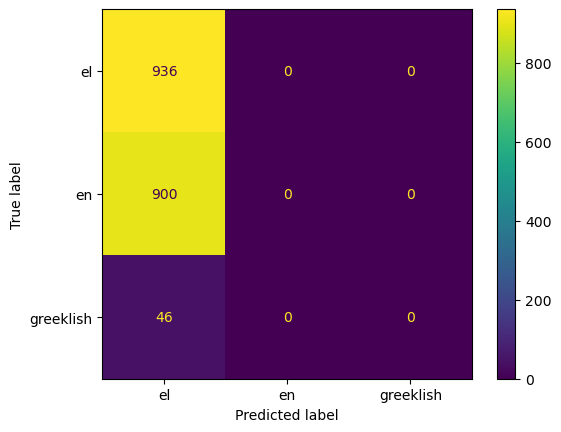

In [51]:
from sklearn.dummy import DummyClassifier, DummyRegressor

majority = DummyClassifier(strategy="most_frequent")
majority.fit(x_train, y_train)
majority_res = majority.predict(x_test)

get_statistics(y_test, majority_res)

### Regex Classification

In [52]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    regex_model = RegexClassifier()
    res = cross_val_res(regex_model, data_train.text, y_train, scoring="f1_macro")
    print(f"Regex Classifier mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Regex Classifier mean macro F1: 0.6594, std: 0.6604


Macro F1: 0.6583604189237992
              precision    recall  f1-score   support

          el       1.00      1.00      1.00       936
          en       0.95      1.00      0.98       900
   greeklish       0.00      0.00      0.00        46

    accuracy                           0.98      1882
   macro avg       0.65      0.67      0.66      1882
weighted avg       0.95      0.98      0.96      1882



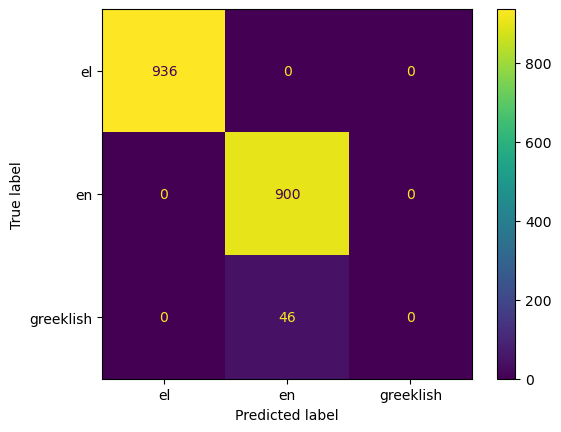

In [53]:
regex_model = RegexClassifier(include_greeklish=True).fit(data_train.text, y_train)
regex_res = regex_model.predict(data_test.text)
get_statistics(y_test, regex_res)

### Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression


with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.8925, std: 0.9440


Macro F1: 0.9313338488630643
              precision    recall  f1-score   support

          el       0.98      1.00      0.99       936
          en       1.00      1.00      1.00       900
   greeklish       1.00      0.67      0.81        46

    accuracy                           0.99      1882
   macro avg       0.99      0.89      0.93      1882
weighted avg       0.99      0.99      0.99      1882



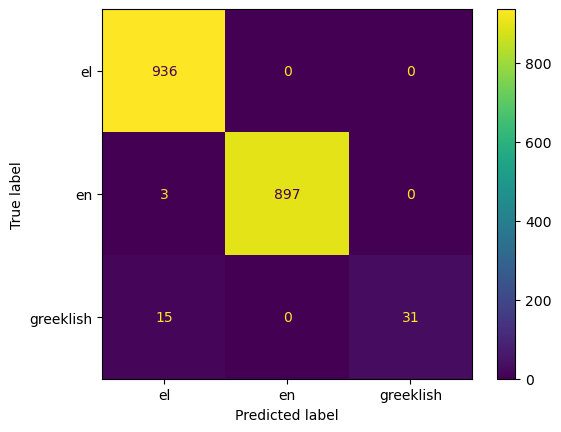

In [55]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

get_statistics(y_test, lr_res)

In [66]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=100, criterion="entropy")
res = cross_val_res(forest_model, x_train, y_train, cv=5)
print(f"Random Forest mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Random Forest mean macro F1: 0.9436, std: 0.9353


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Macro F1: 0.9487505259602503
              precision    recall  f1-score   support

          el       1.00      0.99      0.99       936
          en       1.00      1.00      1.00       900
   greeklish       0.77      0.96      0.85        46

    accuracy                           0.99      1882
   macro avg       0.92      0.98      0.95      1882
weighted avg       0.99      0.99      0.99      1882



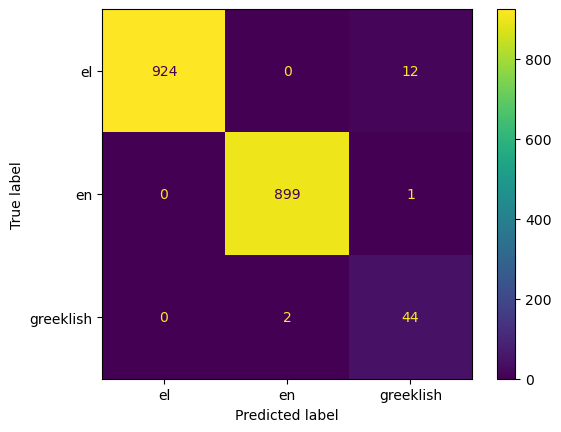

In [64]:
forest_model = RandomForestClassifier(n_estimators=100, criterion="entropy", verbose=1).fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
get_statistics(y_test, forest_pred)

### Adaboost

In [68]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=50)
res = cross_val_res(ada_model, x_train, y_train, cv=5)
print(f"AdaBoost mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost mean macro F1: 0.9366, std: 0.9575


Macro F1: 0.9436649487719944
              precision    recall  f1-score   support

          el       0.98      1.00      0.99       936
          en       1.00      0.99      1.00       900
   greeklish       0.95      0.76      0.84        46

    accuracy                           0.99      1882
   macro avg       0.98      0.92      0.94      1882
weighted avg       0.99      0.99      0.99      1882



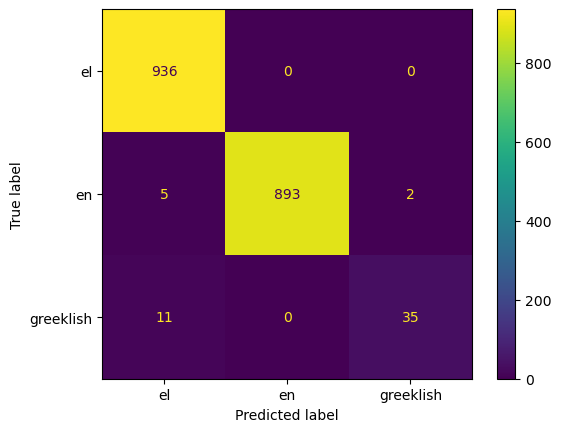

In [69]:
ada_model = AdaBoostClassifier(n_estimators=300).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
get_statistics(y_test, ada_pred)

In [79]:
missed = y_test != ada_pred
pd.DataFrame({"predicted": ada_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
2558328,el,greeklish,ti 8a kanete kamia guild h mpa?
2936352,el,greeklish,Yparxei kapoio ellinko guild pou kanei recruit...
3185767,el,greeklish,"????????? ??????, ????? ?? ??? alliance. /w Mitce"
2866716,el,greeklish,Yparxei ellhniko guild ston outland??
3130093,el,greeklish,"emeis paizoume icecrown alliance an 8elete, ei..."
33971,el,en,Snap kept coming undone.
19331,el,en,FAULTY - All stopped functioning within 1 week
18710,el,en,WERE IMPROPERLY SEWEN
2480452,el,greeklish,mlkia eimai horde :(
45160,greeklish,en,Similar to other books


In [80]:
missed = y_test != forest_pred
pd.DataFrame({"predicted": forest_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
2697,greeklish,el,Εθνικό Ίδρυμα Επιστημών .
7628,greeklish,el,Προκάλεσε κάποια ζημιά .
2792275,en,greeklish,Meta to xtesino mas raid ICC25 exume 8/12hc ...
55944,greeklish,el,"Ο ' λφρεντ ίγκλθορπ , φυσικά !"
54543,greeklish,el,Τέχνη πλασάρισμα
49388,greeklish,el,Διεξήχθη σιωπηλά .
33971,greeklish,en,Snap kept coming undone.
27499,greeklish,el,Σ ' ευχαριστώ .
2868797,greeklish,el,Υπάρχει ελληνικό PVE guild στον icecrown?
84516,greeklish,el,Πρωτότυπα Μηχανολογικά πρωτότυπα (εικονικά ή ...


In [56]:
print(f"Notebook executed in {int((time()-start)// 60)} minutes and {(time()-start) % 60:.1f} seconds")

Notebook executed in 12 minutes and 4.0 seconds
